# Face Mask Segmentation: Traditional Techniques and U-Net

This notebook implements the segmentation tasks for the Face Mask Detection, Classification, and Segmentation project. It includes:

- **Task c: Region Segmentation Using Traditional Techniques** (thresholding)
- **Task d: Mask Segmentation Using U-Net** (deep learning with IoU evaluation)

The code is divided into three main sections:
1. Preprocessing: Converts images to grayscale and resizes them to 64x64.
2. Traditional Segmentation: Applies thresholding to segment mask regions.
3. U-Net Segmentation: Trains a U-Net model for precise mask segmentation and compares it with traditional segmentation using IoU scores.

## Prerequisites
- Ensure the `mask` and `s_mask` folders from the MFSD dataset (https://github.com/sadjadrz/MFSD) are in the same directory as this notebook.
- Required libraries: `os`, `cv2`, `numpy`, `tensorflow`, `matplotlib`.

## How to Run the Notebook

1. **Setup**:
   - Ensure the `mask` and `s_mask` folders from the MFSD dataset (https://github.com/sadjadrz/MFSD) are in the same directory as this notebook.
   - Install required libraries:
     ```bash
     pip install opencv-python numpy tensorflow matplotlib

In [2]:
# Code Block 1: Preprocessing
import os
import cv2
import numpy as np

# Get the current directory
current_dir = os.getcwd()

# Define subfolder paths
original_dir = os.path.join(current_dir, "mask")  # Folder for original masked images
masked_dir = os.path.join(current_dir, "s_mask")  # Folder for binary ground truth masks
preprocessed_original_images = os.path.join(current_dir, "P_mask")  # Folder for preprocessed grayscale masked images
preprocessed_ground_truth_masks = os.path.join(current_dir, "P_s_mask")  # Folder for preprocessed ground truth masks

# Create output directories if they don't exist
os.makedirs(preprocessed_original_images, exist_ok=True)
os.makedirs(preprocessed_ground_truth_masks, exist_ok=True)

# Target shape for resizing
target_shape = (64, 64)

# Function to preprocess images
def preprocess_images(original_dir, masked_dir, preprocessed_original_images, preprocessed_ground_truth_masks):
    files = [f for f in os.listdir(original_dir) if f.endswith((".jpg", ".png"))]
    processed_count = 0
    
    for i, filename in enumerate(files):
        original_path = os.path.join(original_dir, filename)
        mask_path = os.path.join(masked_dir, filename)
        
        # Load original image and mask
        original_img = cv2.imread(original_path)
        mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) if os.path.exists(mask_path) else None
        
        # Check if both images exist
        if original_img is None or mask_img is None:
            print(f"Skipping {filename}: Missing image or mask.")
            continue
        
        # Convert to grayscale and resize
        gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
        resized_gray = cv2.resize(gray_img, target_shape, interpolation=cv2.INTER_AREA)
        resized_mask = cv2.resize(mask_img, target_shape, interpolation=cv2.INTER_NEAREST)
        
        # Save preprocessed images
        cv2.imwrite(os.path.join(preprocessed_original_images, f"gray_{filename}"), resized_gray)
        cv2.imwrite(os.path.join(preprocessed_ground_truth_masks, f"mask_{filename}"), resized_mask)
        processed_count += 1
        
        # Print progress for every 500th image
        if i % 500 == 0:
            print(f"Saved preprocessed masked image: {os.path.join(preprocessed_original_images, f'gray_{filename}')}")
            print(f"Saved preprocessed ground truth mask: {os.path.join(preprocessed_ground_truth_masks, f'mask_{filename}')}")
    
    if processed_count > 0:
        print(f"✅ Preprocessing completed! Processed {processed_count} image pairs. Original images are unchanged.")
    else:
        print("❌ No valid image pairs were processed.")

# Run preprocessing
preprocess_images(original_dir, masked_dir, preprocessed_original_images, preprocessed_ground_truth_masks)

Saved preprocessed masked image: C:\Users\Naval Kishore\Desktop\vr_mini\test 2\P_mask\gray_000000_1.jpg
Saved preprocessed ground truth mask: C:\Users\Naval Kishore\Desktop\vr_mini\test 2\P_s_mask\mask_000000_1.jpg
Saved preprocessed masked image: C:\Users\Naval Kishore\Desktop\vr_mini\test 2\P_mask\gray_000343_2.jpg
Saved preprocessed ground truth mask: C:\Users\Naval Kishore\Desktop\vr_mini\test 2\P_s_mask\mask_000343_2.jpg
Skipping 000601_1.jpg: Missing image or mask.
Saved preprocessed masked image: C:\Users\Naval Kishore\Desktop\vr_mini\test 2\P_mask\gray_000793_1.jpg
Saved preprocessed ground truth mask: C:\Users\Naval Kishore\Desktop\vr_mini\test 2\P_s_mask\mask_000793_1.jpg
Saved preprocessed masked image: C:\Users\Naval Kishore\Desktop\vr_mini\test 2\P_mask\gray_001217_1.jpg
Saved preprocessed ground truth mask: C:\Users\Naval Kishore\Desktop\vr_mini\test 2\P_s_mask\mask_001217_1.jpg
Saved preprocessed masked image: C:\Users\Naval Kishore\Desktop\vr_mini\test 2\P_mask\gray_001

In [3]:
# Code Block 2: Traditional Segmentation
import os
import cv2
import numpy as np

# Get the current directory
current_dir = os.getcwd()

# Define subfolder paths
preprocessed_original_images = os.path.join(current_dir, "P_mask")  # Folder for preprocessed grayscale masked images
preprocessed_ground_truth_masks = os.path.join(current_dir, "P_s_mask")  # Folder for preprocessed ground truth masks
output_dir = os.path.join(current_dir, "segmented_images")  # Folder for segmented images

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Function for traditional segmentation
def traditional_segmentation(preprocessed_original_images, preprocessed_ground_truth_masks, output_dir):
    files = [f for f in os.listdir(preprocessed_original_images) if f.startswith("gray_") and f.endswith((".jpg", ".png"))]
    processed_count = 0
    
    for i, filename in enumerate(files):
        img_path = os.path.join(preprocessed_original_images, filename)
        mask_filename = filename.replace("gray_", "mask_")
        mask_path = os.path.join(preprocessed_ground_truth_masks, mask_filename)

        # Read grayscale image
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if gray_img is None:
            print(f"Failed to load: {img_path}")
            continue
        
        # Apply thresholding
        _, thresh_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Save result
        output_path = os.path.join(output_dir, f"seg_{filename}")
        cv2.imwrite(output_path, thresh_img)
        processed_count += 1

        # Print progress for every 500th image
        if i % 500 == 0:
            print(f"Saved segmented image: {output_path}")
    
    if processed_count > 0:
        print(f"✅ Traditional Segmentation Completed! Processed {processed_count} images.")
    else:
        print("❌ No images were segmented.")

# Run traditional segmentation
traditional_segmentation(preprocessed_original_images, preprocessed_ground_truth_masks, output_dir)

Saved segmented image: C:\Users\Naval Kishore\Desktop\vr_mini\test 2\segmented_images\seg_gray_000000_1.jpg
Saved segmented image: C:\Users\Naval Kishore\Desktop\vr_mini\test 2\segmented_images\seg_gray_000343_2.jpg
Saved segmented image: C:\Users\Naval Kishore\Desktop\vr_mini\test 2\segmented_images\seg_gray_000793_1.jpg
Saved segmented image: C:\Users\Naval Kishore\Desktop\vr_mini\test 2\segmented_images\seg_gray_001217_1.jpg
Saved segmented image: C:\Users\Naval Kishore\Desktop\vr_mini\test 2\segmented_images\seg_gray_001579_1.jpg
Saved segmented image: C:\Users\Naval Kishore\Desktop\vr_mini\test 2\segmented_images\seg_gray_002015_1.jpg
Saved segmented image: C:\Users\Naval Kishore\Desktop\vr_mini\test 2\segmented_images\seg_gray_002486_2.jpg
Saved segmented image: C:\Users\Naval Kishore\Desktop\vr_mini\test 2\segmented_images\seg_gray_002963_2.jpg
Saved segmented image: C:\Users\Naval Kishore\Desktop\vr_mini\test 2\segmented_images\seg_gray_003435_1.jpg
Saved segmented image: C:\Us

No matching ground truth mask found for gray_000601_1.jpg, skipping.
✅ Loaded 9382 image pairs for training.
Training set size: 7506, Validation set size: 1876
Starting training with 7506 images, batch size 100
Epoch 1/2
76/76 ━━━━━━━━━━━━━━━━━━━━ 430s 6s/step - accuracy: 0.5762 - loss: 0.6555 - val_accuracy: 0.5503 - val_loss: 0.5938
Epoch 2/2
76/76 ━━━━━━━━━━━━━━━━━━━━ 433s 6s/step - accuracy: 0.5417 - loss: 0.5247 - val_accuracy: 0.6444 - val_loss: 0.3619


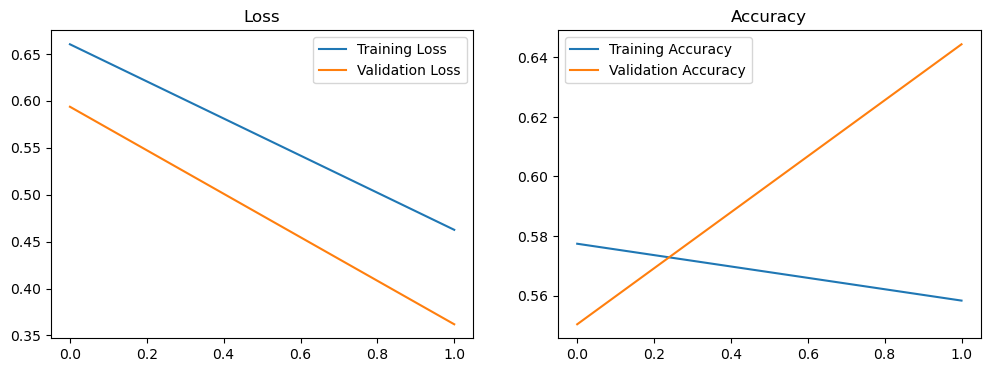

Generating predictions...
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step
Average IoU for U-Net: 0.4901
Average IoU for Traditional Segmentation: 0.2761
Difference (U-Net - Traditional): 0.2141


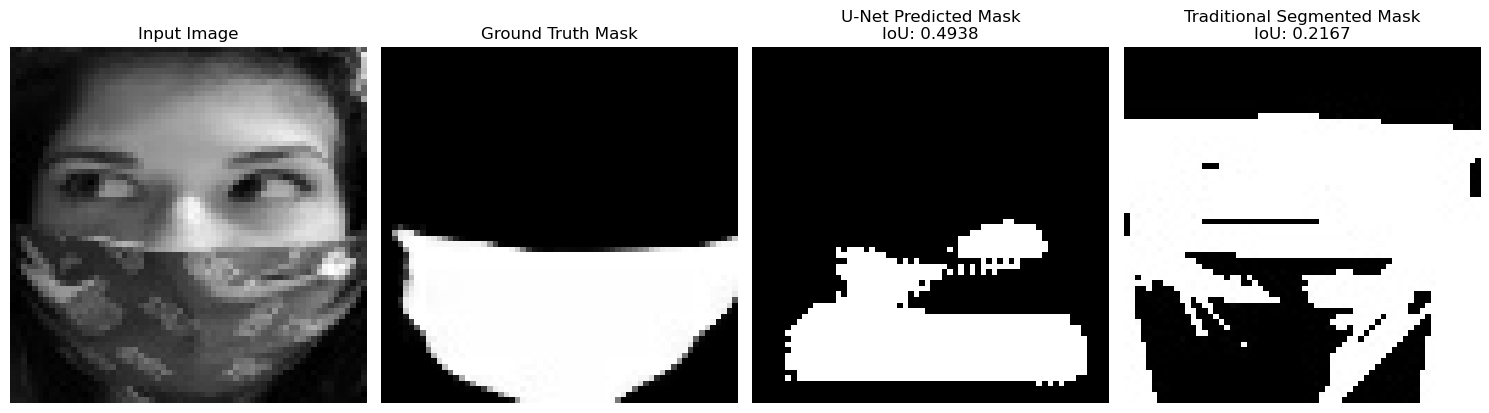

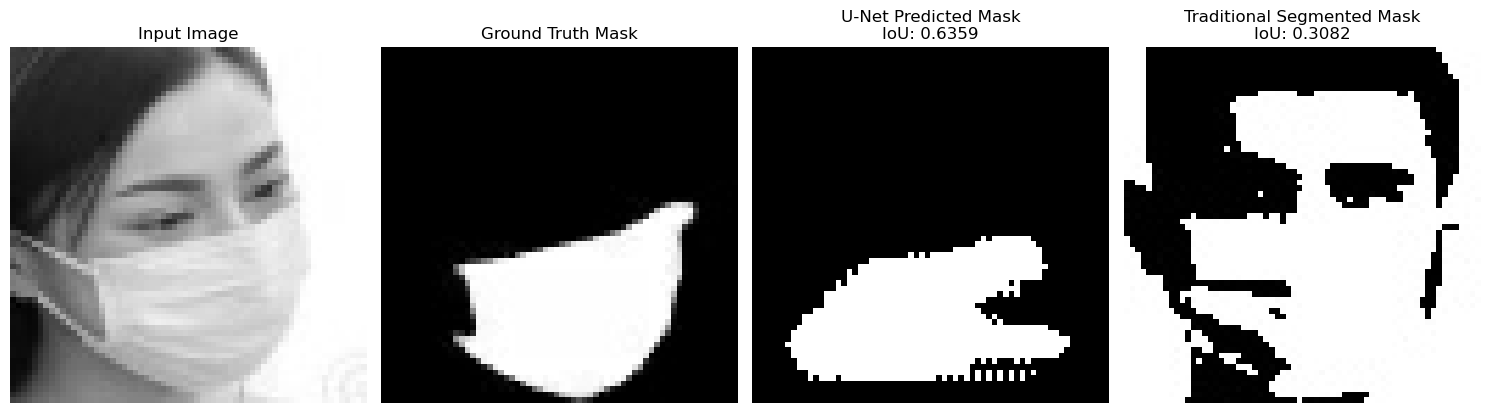

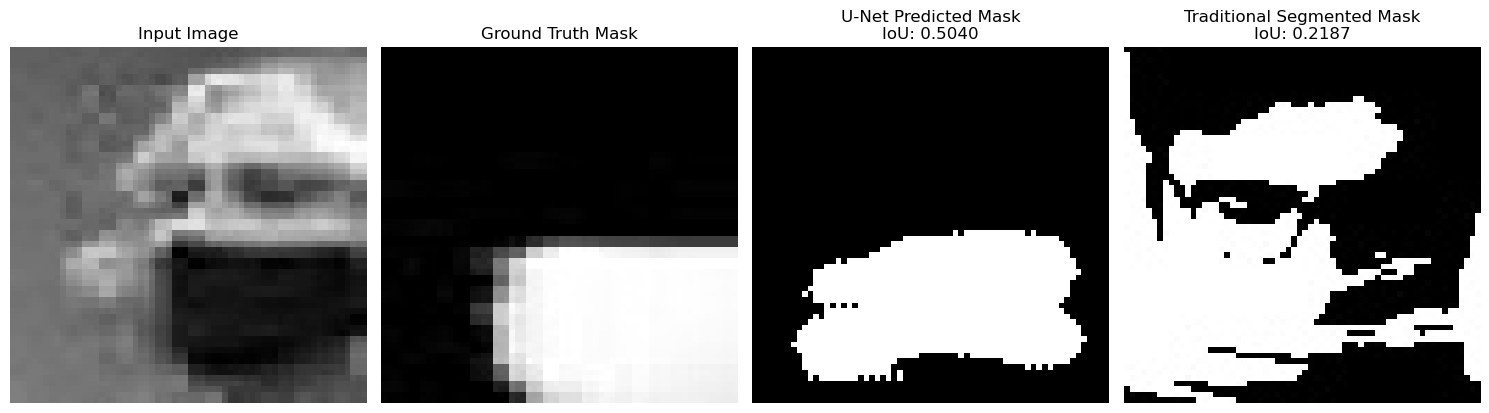

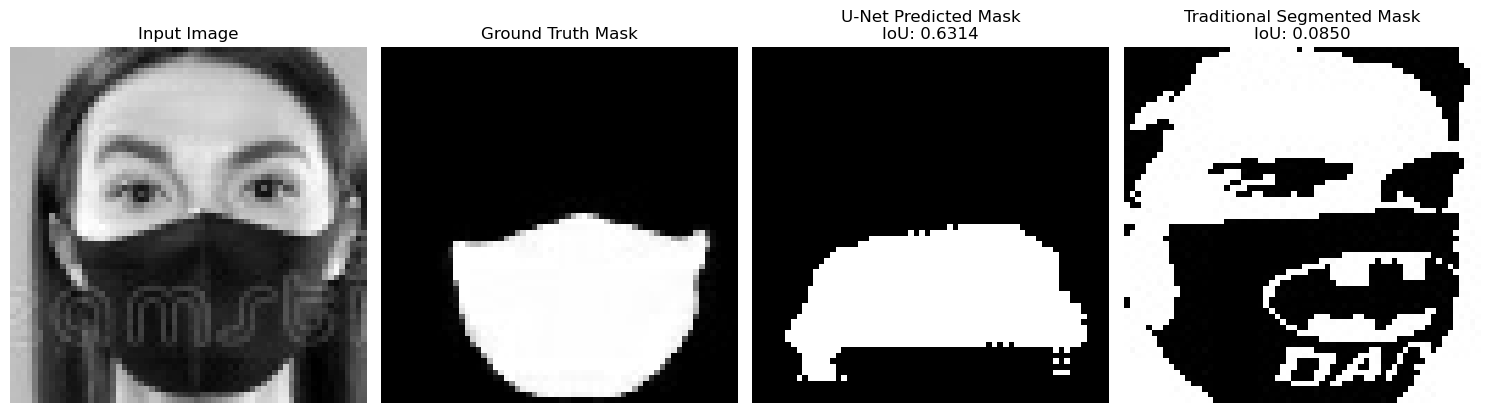

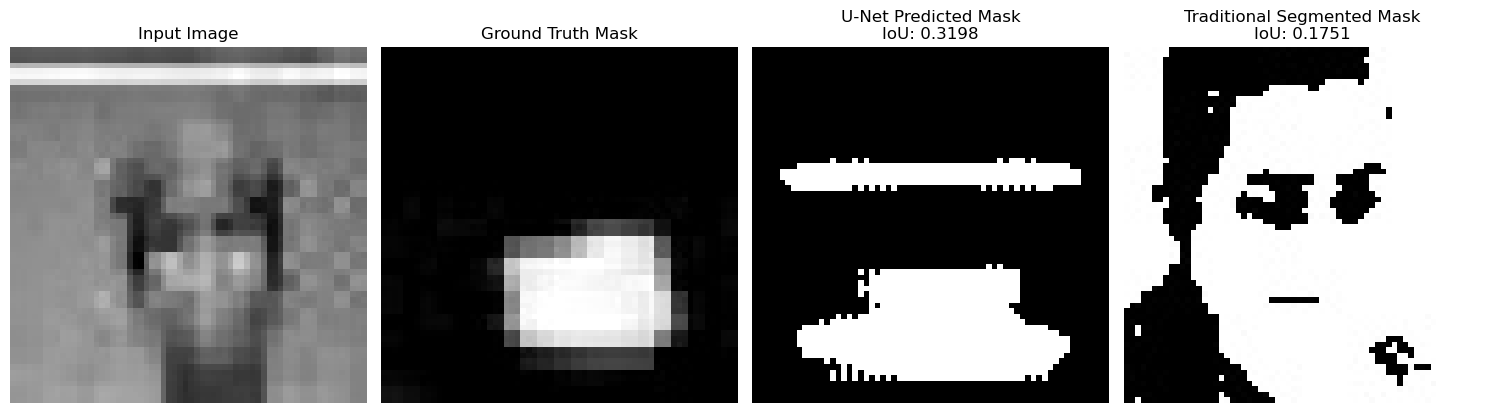

Model saved to C:\Users\Naval Kishore\Desktop\vr_mini\test 2\unet_model.h5
✅ Training and prediction completed successfully!


In [4]:
# Code Block 3: U-Net Training and Prediction
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Get the current directory
current_dir = os.getcwd()

# Define subfolder paths
preprocessed_original_images = os.path.join(current_dir, "P_mask")  # Folder for preprocessed grayscale masked images
preprocessed_ground_truth_masks = os.path.join(current_dir, "P_s_mask")  # Folder for preprocessed ground truth masks
output_dir = os.path.join(current_dir, "segmented_images")  # Folder for segmented images

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define image parameters
IMG_HEIGHT = 64
IMG_WIDTH = 64
IMG_CHANNELS = 1
BATCH_SIZE = 100  # Updated to match your run
EPOCHS = 2  # Updated to match your run
VALIDATION_SPLIT = 0.2  # 20% for validation

# Function to calculate IoU score
def calculate_iou(y_true, y_pred, threshold=0.5):
    # Binarize predictions
    y_pred = (y_pred > threshold).astype(np.uint8)
    y_true = (y_true > 0.5).astype(np.uint8)

    # Flatten arrays for easier computation
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Calculate intersection and union
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection

    # Avoid division by zero
    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    iou = intersection / union
    return iou

# U-Net model definition
def unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    model = models.Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Data generator function using tf.data.Dataset
def create_dataset(image_dir, mask_dir, batch_size):
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.startswith("gray_") and f.endswith((".jpg", ".png"))]
    mask_paths = []
    valid_image_paths = []
    
    for img_path in image_paths:
        filename = os.path.basename(img_path)
        base_filename = filename.replace("gray_", "")
        mask_path = os.path.join(mask_dir, f"mask_{base_filename}")
        
        if os.path.exists(mask_path):
            valid_image_paths.append(img_path)
            mask_paths.append(mask_path)
        else:
            print(f"No matching ground truth mask found for {filename}, skipping.")

    if not valid_image_paths:
        raise ValueError("No valid image-mask pairs found. Check your dataset and naming conventions.")

    def load_and_preprocess_image(img_path, mask_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.cast(img, tf.float32)  # Cast to float32 before division
        img = img / 255.0

        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_jpeg(mask, channels=IMG_CHANNELS)
        mask = tf.cast(mask, tf.float32)  # Cast to float32 before division
        mask = mask / 255.0

        return img, mask

    dataset = tf.data.Dataset.from_tensor_slices((valid_image_paths, mask_paths))
    # Specify output shapes to avoid unknown TensorShape error
    dataset = dataset.map(
        lambda x, y: tf.numpy_function(
            load_and_preprocess_image, [x, y], [tf.float32, tf.float32]
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    ).map(
        lambda x, y: (tf.ensure_shape(x, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS]), 
                      tf.ensure_shape(y, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS]))
    )
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset, len(valid_image_paths), valid_image_paths

# Split dataset into training and validation
def split_dataset(dataset, dataset_size, validation_split):
    val_size = int(dataset_size * validation_split)
    train_size = dataset_size - val_size

    train_dataset = dataset.take(train_size).batch(BATCH_SIZE)
    val_dataset = dataset.skip(train_size).batch(BATCH_SIZE)

    return train_dataset, val_dataset, train_size, val_size

# Load traditional segmentation results for comparison
def load_traditional_segmentation(image_paths, output_dir):
    traditional_preds = []
    for img_path in image_paths:
        filename = os.path.basename(img_path)
        trad_seg_path = os.path.join(output_dir, f"seg_{filename}")
        if os.path.exists(trad_seg_path):
            trad_seg = cv2.imread(trad_seg_path, cv2.IMREAD_GRAYSCALE)
            trad_seg = trad_seg / 255.0  # Normalize to [0, 1]
            trad_seg = np.expand_dims(trad_seg, axis=-1)
            traditional_preds.append(trad_seg)
        else:
            print(f"Traditional segmentation not found for {filename}, skipping.")
            traditional_preds.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, 1)))  # Placeholder
    return np.array(traditional_preds)

# Train and predict using U-Net
def train_and_predict():
    # Create dataset
    dataset, dataset_size, image_paths = create_dataset(preprocessed_original_images, preprocessed_ground_truth_masks, BATCH_SIZE)
    print(f"✅ Loaded {dataset_size} image pairs for training.")

    # Split dataset into training and validation
    train_dataset, val_dataset, train_size, val_size = split_dataset(dataset, dataset_size, VALIDATION_SPLIT)
    print(f"Training set size: {train_size}, Validation set size: {val_size}")

    # Train U-Net with early stopping
    model = unet_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    print(f"Starting training with {train_size} images, batch size {BATCH_SIZE}")
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=[early_stopping]
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

    # Prediction (limited to first 100 samples for speed)
    print("Generating predictions...")
    predictions = []
    images_list = []
    masks_list = []
    for i, (images, masks) in enumerate(val_dataset.take(100 // BATCH_SIZE + 1)):
        preds = model.predict(images)
        predictions.extend(preds)
        images_list.extend(images.numpy())
        masks_list.extend(masks.numpy())
    
    predictions = np.array(predictions)
    images_list = np.array(images_list)
    masks_list = np.array(masks_list)
    predictions = (predictions > 0.5).astype(np.uint8)  # Binarize predictions

    # Load traditional segmentation results
    traditional_preds = load_traditional_segmentation(image_paths[:len(predictions)], output_dir)

    # Calculate IoU scores
    unet_ious = []
    trad_ious = []
    for i in range(len(predictions)):
        unet_iou = calculate_iou(masks_list[i], predictions[i])
        trad_iou = calculate_iou(masks_list[i], traditional_preds[i])
        unet_ious.append(unet_iou)
        trad_ious.append(trad_iou)

    # Compute average IoU scores
    avg_unet_iou = np.mean(unet_ious)
    avg_trad_iou = np.mean(trad_ious)
    print(f"Average IoU for U-Net: {avg_unet_iou:.4f}")
    print(f"Average IoU for Traditional Segmentation: {avg_trad_iou:.4f}")
    print(f"Difference (U-Net - Traditional): {avg_unet_iou - avg_trad_iou:.4f}")

    # Save and visualize results (first 5 samples)
    for i in range(min(5, len(predictions))):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(images_list[i].squeeze(), cmap='gray')
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(masks_list[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title(f"U-Net Predicted Mask\nIoU: {unet_ious[i]:.4f}")
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(traditional_preds[i].squeeze(), cmap='gray')
        plt.title(f"Traditional Segmented Mask\nIoU: {trad_ious[i]:.4f}")
        plt.axis('off')

        # Save the U-Net prediction
        output_path = os.path.join(output_dir, f"unet_pred_{i}.png")
        cv2.imwrite(output_path, predictions[i].squeeze() * 255)
        
        plt.tight_layout()
        plt.show()

    # Save model
    model.save(os.path.join(current_dir, "unet_model.h5"))
    print(f"Model saved to {os.path.join(current_dir, 'unet_model.h5')}")
    print("✅ Training and prediction completed successfully!")

# Run the U-Net pipeline
try:
    train_and_predict()
except Exception as e:
    print(f"❌ An error occurred: {str(e)}")

No matching ground truth mask found for gray_000601_1.jpg, skipping.
✅ Loaded 9382 image pairs for training.
Training set size: 7506, Validation set size: 1876
Starting training with 7506 images, batch size 1000
Epoch 1/2
8/8 ━━━━━━━━━━━━━━━━━━━━ 801s 98s/step - accuracy: 0.6021 - loss: 0.6683 - val_accuracy: 0.6367 - val_loss: 0.6586
Epoch 2/2
8/8 ━━━━━━━━━━━━━━━━━━━━ 842s 102s/step - accuracy: 0.6051 - loss: 0.6645 - val_accuracy: 0.6367 - val_loss: 0.6251


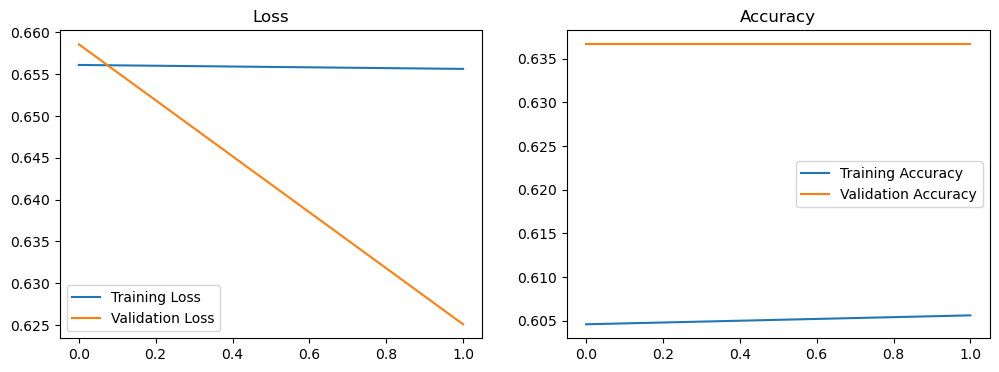

Generating predictions...
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 442ms/step
Average IoU for U-Net: 0.0020
Average IoU for Traditional Segmentation: 0.2338
Difference (U-Net - Traditional): -0.2318


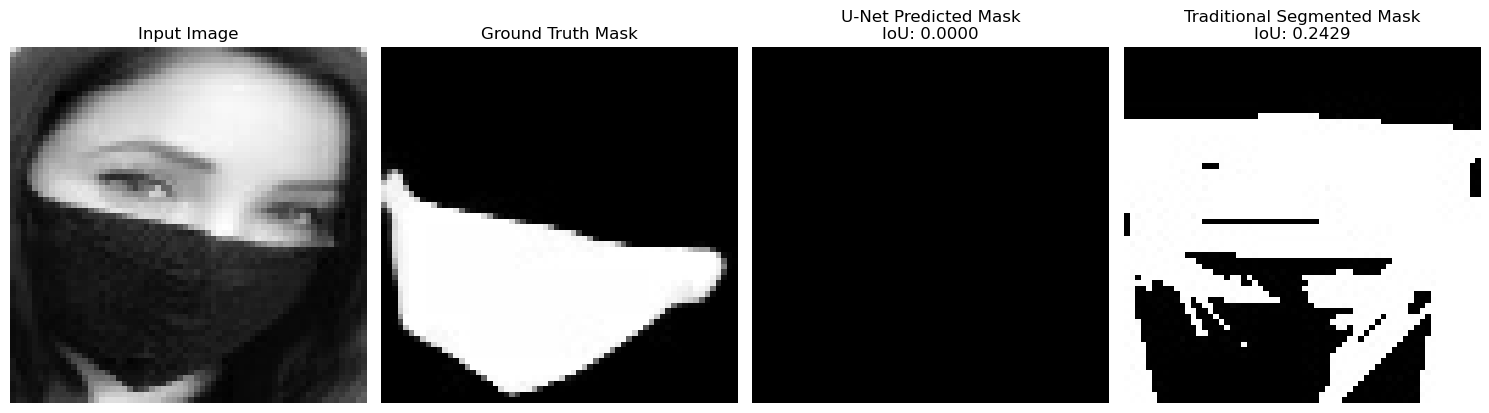

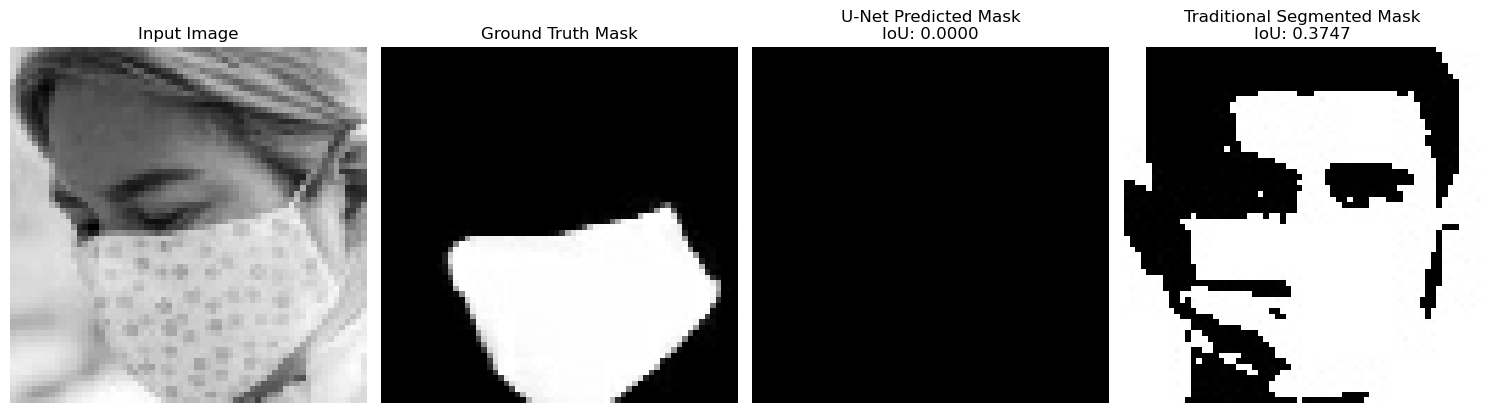

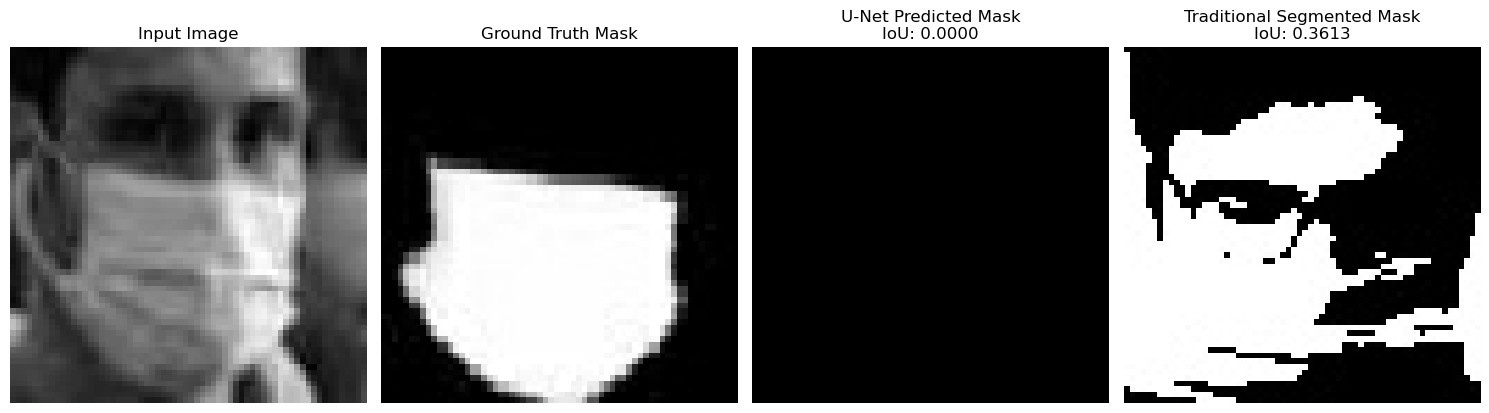

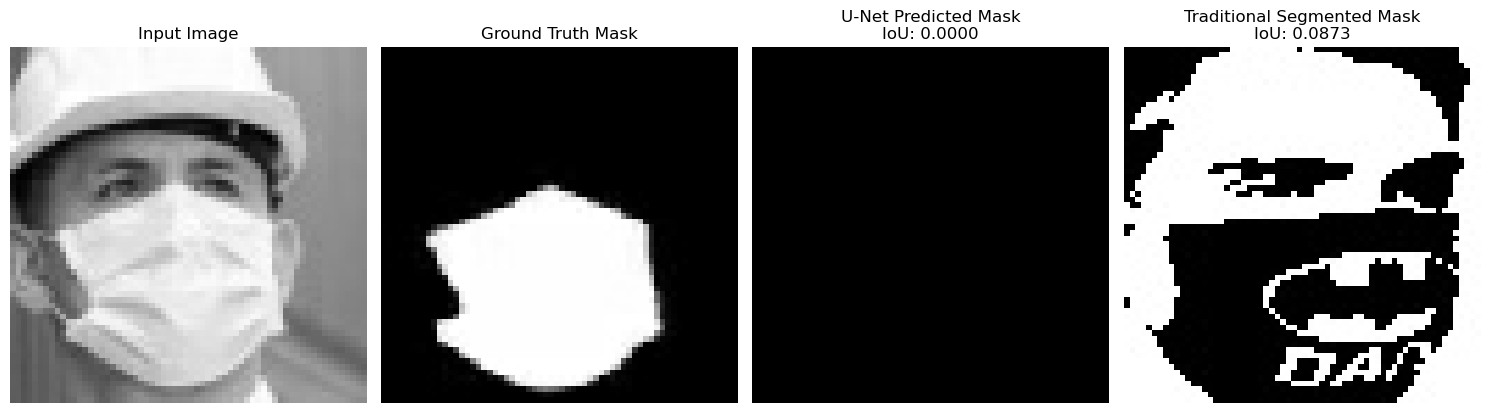

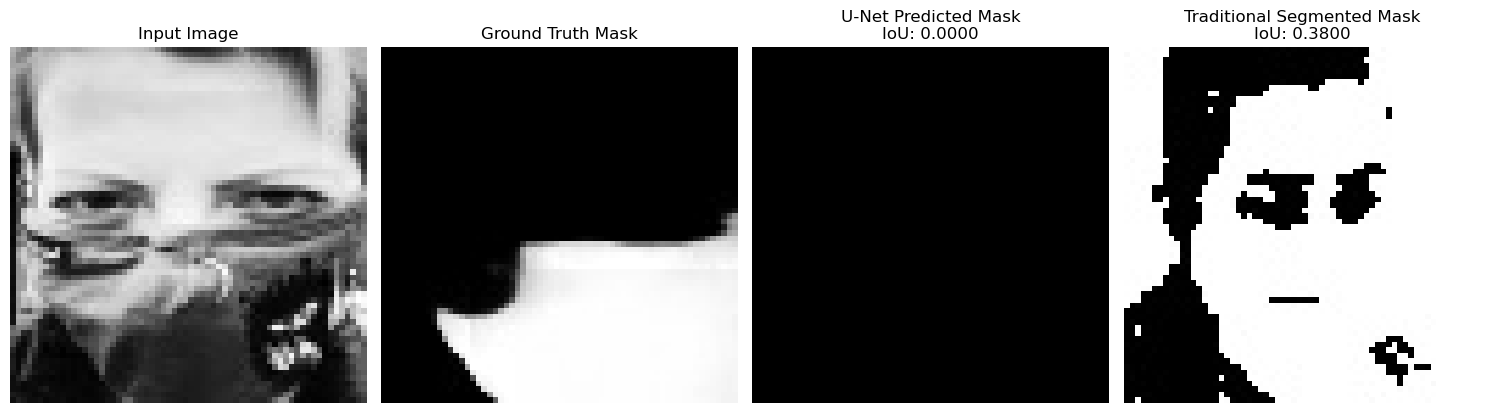

Model saved to C:\Users\Naval Kishore\Desktop\vr_mini\test 2\unet_model.h5
✅ Training and prediction completed successfully!


In [1]:

# Code Block 3: U-Net Training and Prediction
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Get the current directory
current_dir = os.getcwd()

# Define subfolder paths
preprocessed_original_images = os.path.join(current_dir, "P_mask")  # Folder for preprocessed grayscale masked images
preprocessed_ground_truth_masks = os.path.join(current_dir, "P_s_mask")  # Folder for preprocessed ground truth masks
output_dir = os.path.join(current_dir, "segmented_images")  # Folder for segmented images

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define image parameters
IMG_HEIGHT = 64
IMG_WIDTH = 64
IMG_CHANNELS = 1
BATCH_SIZE = 100
EPOCHS = 2
VALIDATION_SPLIT = 0.2

# Function to calculate IoU score
def calculate_iou(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.uint8)
    y_true = (y_true > 0.5).astype(np.uint8)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    iou = intersection / union
    return iou

# U-Net model definition (unchanged)
def unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    u4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    u5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Data generator function (unchanged)
def create_dataset(image_dir, mask_dir, batch_size):
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.startswith("gray_") and f.endswith((".jpg", ".png"))]
    mask_paths = []
    valid_image_paths = []
    for img_path in image_paths:
        filename = os.path.basename(img_path)
        base_filename = filename.replace("gray_", "")
        mask_path = os.path.join(mask_dir, f"mask_{base_filename}")
        if os.path.exists(mask_path):
            valid_image_paths.append(img_path)
            mask_paths.append(mask_path)
        else:
            print(f"No matching ground truth mask found for {filename}, skipping.")
    if not valid_image_paths:
        raise ValueError("No valid image-mask pairs found. Check your dataset and naming conventions.")
    def load_and_preprocess_image(img_path, mask_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.cast(img, tf.float32)
        img = img / 255.0
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_jpeg(mask, channels=IMG_CHANNELS)
        mask = tf.cast(mask, tf.float32)
        mask = mask / 255.0
        return img, mask
    dataset = tf.data.Dataset.from_tensor_slices((valid_image_paths, mask_paths))
    dataset = dataset.map(
        lambda x, y: tf.numpy_function(
            load_and_preprocess_image, [x, y], [tf.float32, tf.float32]
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    ).map(
        lambda x, y: (tf.ensure_shape(x, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS]), 
                      tf.ensure_shape(y, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS]))
    )
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset, len(valid_image_paths), valid_image_paths

# Split dataset (unchanged)
def split_dataset(dataset, dataset_size, validation_split):
    val_size = int(dataset_size * validation_split)
    train_size = dataset_size - val_size
    train_dataset = dataset.take(train_size).batch(BATCH_SIZE)
    val_dataset = dataset.skip(train_size).batch(BATCH_SIZE)
    return train_dataset, val_dataset, train_size, val_size

# Modified: Load traditional segmentation for specific validation image paths
def load_traditional_segmentation(val_image_paths, output_dir):
    traditional_preds = []
    for img_path in val_image_paths:  # Use the exact validation image paths
        filename = os.path.basename(img_path)
        trad_seg_path = os.path.join(output_dir, f"seg_{filename}")
        if os.path.exists(trad_seg_path):
            trad_seg = cv2.imread(trad_seg_path, cv2.IMREAD_GRAYSCALE)
            trad_seg = trad_seg / 255.0
            trad_seg = np.expand_dims(trad_seg, axis=-1)
            traditional_preds.append(trad_seg)
        else:
            print(f"Traditional segmentation not found for {filename}, skipping.")
            traditional_preds.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, 1)))
    return np.array(traditional_preds)

# Modified: Train and predict with aligned traditional segmentation
def train_and_predict():
    # Create dataset
    dataset, dataset_size, image_paths = create_dataset(preprocessed_original_images, preprocessed_ground_truth_masks, BATCH_SIZE)
    print(f"✅ Loaded {dataset_size} image pairs for training.")

    # Split dataset
    train_dataset, val_dataset, train_size, val_size = split_dataset(dataset, dataset_size, VALIDATION_SPLIT)
    print(f"Training set size: {train_size}, Validation set size: {val_size}")

    # Train U-Net
    model = unet_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    print(f"Starting training with {train_size} images, batch size {BATCH_SIZE}")
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=[early_stopping]
    )

    # Plot training history (unchanged)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

    # Prediction with validation image paths tracking
    print("Generating predictions...")
    predictions = []
    images_list = []
    masks_list = []
    val_image_paths = []  # Track validation image paths
    for i, (images, masks) in enumerate(val_dataset.take(100 // BATCH_SIZE + 1)):
        preds = model.predict(images)
        predictions.extend(preds)
        images_list.extend(images.numpy())
        masks_list.extend(masks.numpy())
        # Get corresponding image paths for this batch
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, len(image_paths))
        val_image_paths.extend(image_paths[batch_start:batch_end][:len(images)])

    predictions = np.array(predictions)
    images_list = np.array(images_list)
    masks_list = np.array(masks_list)
    predictions = (predictions > 0.5).astype(np.uint8)

    # Load traditional segmentation for the same validation images
    traditional_preds = load_traditional_segmentation(val_image_paths[:len(predictions)], output_dir)

    # Calculate IoU scores
    unet_ious = []
    trad_ious = []
    for i in range(len(predictions)):
        unet_iou = calculate_iou(masks_list[i], predictions[i])
        trad_iou = calculate_iou(masks_list[i], traditional_preds[i])
        unet_ious.append(unet_iou)
        trad_ious.append(trad_iou)

    # Compute average IoU scores
    avg_unet_iou = np.mean(unet_ious)
    avg_trad_iou = np.mean(trad_ious)
    print(f"Average IoU for U-Net: {avg_unet_iou:.4f}")
    print(f"Average IoU for Traditional Segmentation: {avg_trad_iou:.4f}")
    print(f"Difference (U-Net - Traditional): {avg_unet_iou - avg_trad_iou:.4f}")

    # Save and visualize results (first 5 samples)
    for i in range(min(5, len(predictions))):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(images_list[i].squeeze(), cmap='gray')
        plt.title("Input Image")
        plt.axis('off')
        plt.subplot(1, 4, 2)
        plt.imshow(masks_list[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
        plt.subplot(1, 4, 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title(f"U-Net Predicted Mask\nIoU: {unet_ious[i]:.4f}")
        plt.axis('off')
        plt.subplot(1, 4, 4)
        plt.imshow(traditional_preds[i].squeeze(), cmap='gray')
        plt.title(f"Traditional Segmented Mask\nIoU: {trad_ious[i]:.4f}")
        plt.axis('off')
        output_path = os.path.join(output_dir, f"unet_pred_{i}.png")
        cv2.imwrite(output_path, predictions[i].squeeze() * 255)
        plt.tight_layout()
        plt.show()

    # Save model
    model.save(os.path.join(current_dir, "unet_model.h5"))
    print(f"Model saved to {os.path.join(current_dir, 'unet_model.h5')}")
    print("✅ Training and prediction completed successfully!")

# Run the U-Net pipeline
try:
    train_and_predict()
except Exception as e:
    print(f"❌ An error occurred: {str(e)}")

In [ ]:
# Code Block 3: U-Net Training and Prediction
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Get the current directory
current_dir = os.getcwd()

# Define subfolder paths
preprocessed_original_images = os.path.join(current_dir, "P_mask")  # Folder for preprocessed grayscale masked images
preprocessed_ground_truth_masks = os.path.join(current_dir, "P_s_mask")  # Folder for preprocessed ground truth masks
output_dir = os.path.join(current_dir, "segmented_images")  # Folder for segmented images

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define image parameters
IMG_HEIGHT = 64
IMG_WIDTH = 64
IMG_CHANNELS = 1
BATCH_SIZE = 8  # Updated to match your run
EPOCHS = 10  # Updated to match your run
VALIDATION_SPLIT = 0.2  # 20% for validation

# Function to calculate IoU score
def calculate_iou(y_true, y_pred, threshold=0.5):
    # Binarize predictions
    y_pred = (y_pred > threshold).astype(np.uint8)
    y_true = (y_true > 0.5).astype(np.uint8)

    # Flatten arrays for easier computation
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Calculate intersection and union
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection

    # Avoid division by zero
    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    iou = intersection / union
    return iou

# U-Net model definition
def unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    model = models.Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Data generator function using tf.data.Dataset
def create_dataset(image_dir, mask_dir, batch_size):
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.startswith("gray_") and f.endswith((".jpg", ".png"))]
    mask_paths = []
    valid_image_paths = []
    
    for img_path in image_paths:
        filename = os.path.basename(img_path)
        base_filename = filename.replace("gray_", "")
        mask_path = os.path.join(mask_dir, f"mask_{base_filename}")
        
        if os.path.exists(mask_path):
            valid_image_paths.append(img_path)
            mask_paths.append(mask_path)
        else:
            print(f"No matching ground truth mask found for {filename}, skipping.")

    if not valid_image_paths:
        raise ValueError("No valid image-mask pairs found. Check your dataset and naming conventions.")

    def load_and_preprocess_image(img_path, mask_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.cast(img, tf.float32)  # Cast to float32 before division
        img = img / 255.0

        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_jpeg(mask, channels=IMG_CHANNELS)
        mask = tf.cast(mask, tf.float32)  # Cast to float32 before division
        mask = mask / 255.0

        return img, mask

    dataset = tf.data.Dataset.from_tensor_slices((valid_image_paths, mask_paths))
    # Specify output shapes to avoid unknown TensorShape error
    dataset = dataset.map(
        lambda x, y: tf.numpy_function(
            load_and_preprocess_image, [x, y], [tf.float32, tf.float32]
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    ).map(
        lambda x, y: (tf.ensure_shape(x, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS]), 
                      tf.ensure_shape(y, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS]))
    )
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset, len(valid_image_paths), valid_image_paths

# Split dataset into training and validation
def split_dataset(dataset, dataset_size, validation_split):
    val_size = int(dataset_size * validation_split)
    train_size = dataset_size - val_size

    train_dataset = dataset.take(train_size).batch(BATCH_SIZE)
    val_dataset = dataset.skip(train_size).batch(BATCH_SIZE)

    return train_dataset, val_dataset, train_size, val_size

# Load traditional segmentation results for comparison
def load_traditional_segmentation(image_paths, output_dir):
    traditional_preds = []
    for img_path in image_paths:
        filename = os.path.basename(img_path)
        trad_seg_path = os.path.join(output_dir, f"seg_{filename}")
        if os.path.exists(trad_seg_path):
            trad_seg = cv2.imread(trad_seg_path, cv2.IMREAD_GRAYSCALE)
            trad_seg = trad_seg / 255.0  # Normalize to [0, 1]
            trad_seg = np.expand_dims(trad_seg, axis=-1)
            traditional_preds.append(trad_seg)
        else:
            print(f"Traditional segmentation not found for {filename}, skipping.")
            traditional_preds.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, 1)))  # Placeholder
    return np.array(traditional_preds)

# Train and predict using U-Net
def train_and_predict():
    # Create dataset
    dataset, dataset_size, image_paths = create_dataset(preprocessed_original_images, preprocessed_ground_truth_masks, BATCH_SIZE)
    print(f"✅ Loaded {dataset_size} image pairs for training.")

    # Split dataset into training and validation
    train_dataset, val_dataset, train_size, val_size = split_dataset(dataset, dataset_size, VALIDATION_SPLIT)
    print(f"Training set size: {train_size}, Validation set size: {val_size}")

    # Train U-Net with early stopping
    model = unet_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    print(f"Starting training with {train_size} images, batch size {BATCH_SIZE}")
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=[early_stopping]
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

    # Prediction (limited to first 100 samples for speed)
    print("Generating predictions...")
    predictions = []
    images_list = []
    masks_list = []
    for i, (images, masks) in enumerate(val_dataset.take(100 // BATCH_SIZE + 1)):
        preds = model.predict(images)
        predictions.extend(preds)
        images_list.extend(images.numpy())
        masks_list.extend(masks.numpy())
    
    predictions = np.array(predictions)
    images_list = np.array(images_list)
    masks_list = np.array(masks_list)
    predictions = (predictions > 0.5).astype(np.uint8)  # Binarize predictions

    # Load traditional segmentation results
    traditional_preds = load_traditional_segmentation(image_paths[:len(predictions)], output_dir)

    # Calculate IoU scores
    unet_ious = []
    trad_ious = []
    for i in range(len(predictions)):
        unet_iou = calculate_iou(masks_list[i], predictions[i])
        trad_iou = calculate_iou(masks_list[i], traditional_preds[i])
        unet_ious.append(unet_iou)
        trad_ious.append(trad_iou)

    # Compute average IoU scores
    avg_unet_iou = np.mean(unet_ious)
    avg_trad_iou = np.mean(trad_ious)
    print(f"Average IoU for U-Net: {avg_unet_iou:.4f}")
    print(f"Average IoU for Traditional Segmentation: {avg_trad_iou:.4f}")
    print(f"Difference (U-Net - Traditional): {avg_unet_iou - avg_trad_iou:.4f}")

    # Save and visualize results (first 5 samples)
    for i in range(min(5, len(predictions))):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(images_list[i].squeeze(), cmap='gray')
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(masks_list[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title(f"U-Net Predicted Mask\nIoU: {unet_ious[i]:.4f}")
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(traditional_preds[i].squeeze(), cmap='gray')
        plt.title(f"Traditional Segmented Mask\nIoU: {trad_ious[i]:.4f}")
        plt.axis('off')

        # Save the U-Net prediction
        output_path = os.path.join(output_dir, f"unet_pred_{i}.png")
        cv2.imwrite(output_path, predictions[i].squeeze() * 255)
        
        plt.tight_layout()
        plt.show()

    # Save model
    model.save(os.path.join(current_dir, "unet_model2.h5"))
    print(f"Model saved to {os.path.join(current_dir, 'unet_model2.h5')}")
    print("✅ Training and prediction completed successfully!")

# Run the U-Net pipeline
try:
    train_and_predict()
except Exception as e:
    print(f"❌ An error occurred: {str(e)}")

✅ Model is saved at: C:\Users\Naval Kishore\Desktop\vr_mini\test 2\unet_model.h5


Enter Image ID (e.g., '000001_1'):  000009_1


✅ Image loaded successfully.
✅ Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


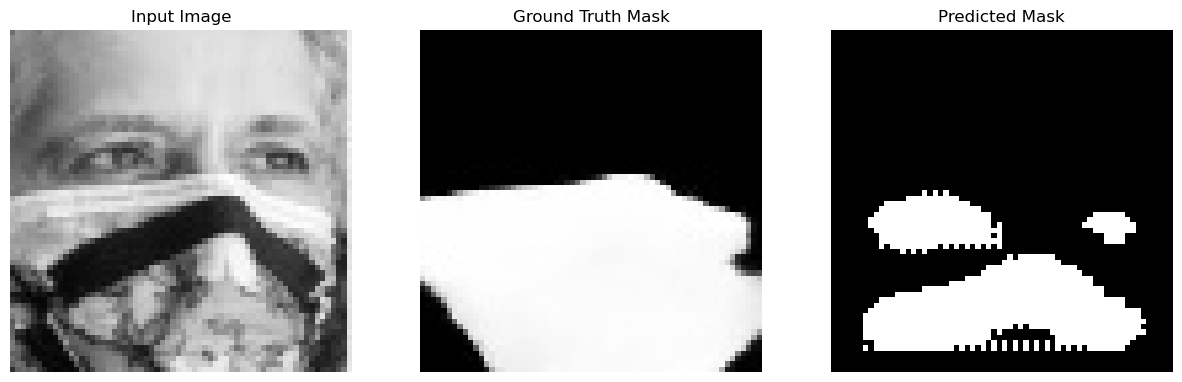

In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ✅ Get the current working directory
current_dir = os.getcwd()

# ✅ Check if the model file exists
model_path = os.path.join(current_dir, "unet_model.h5")
if not os.path.exists(model_path):
    print("❌ Model file not found! Please train or load the model.")
    exit()

print(f"✅ Model is saved at: {model_path}")

# ✅ Define file paths
preprocessed_original_images = os.path.join(current_dir, "P_mask")  # Input images folder
preprocessed_ground_truth_masks = os.path.join(current_dir, "P_s_mask")  # Ground truth masks folder

# ✅ Ask user for image ID (e.g., "000001_1")
image_id = input("Enter Image ID (e.g., '000001_1'): ").strip()

# ✅ Generate filenames dynamically
image_filename = f"gray_{image_id}.jpg"
mask_filename = f"mask_{image_id}.jpg"

image_path = os.path.join(preprocessed_original_images, image_filename)
mask_path = os.path.join(preprocessed_ground_truth_masks, mask_filename)

# ✅ Load Image and Mask
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    print(f"❌ Image not found at {image_path}")
    exit()
if mask is None:
    print(f"⚠️ Ground truth mask not found at {mask_path}. Proceeding without it.")

print("✅ Image loaded successfully.")

# ✅ Load Trained U-Net Model
model = tf.keras.models.load_model(model_path)
print("✅ Model loaded successfully.")

# ✅ Preprocess Image for Model Input
image_resized = cv2.resize(image, (64, 64))  # Ensure correct input size
image_input = np.expand_dims(image_resized, axis=[0, -1]) / 255.0  # Normalize

# ✅ Get Model Prediction
predicted_mask = model.predict(image_input)[0, :, :, 0]  # Extract 1st batch prediction
predicted_mask = (predicted_mask > 0.5).astype(np.uint8) * 255  # Convert to binary

# ✅ Display Input Image, Ground Truth Mask (if available), and Predicted Mask
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Input Image")
plt.axis("off")

if mask is not None:
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


In [6]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ✅ Get the current working directory
current_dir = os.getcwd()

# ✅ Ask user for model number (e.g., 1 for "unet_model1.h5", 2 for "unet_model2.h5")
model_number = input("Enter model number (e.g., '1' for unet_model1.h5): ").strip()
model_filename = f"unet_model{model_number}.h5"  # Dynamically construct model filename
model_path = os.path.join(current_dir, model_filename)

# ✅ Check if the model file exists
if not os.path.exists(model_path):
    print(f"❌ Model file '{model_filename}' not found! Please check the model number.")
    exit()

print(f"✅ Model selected: {model_filename}")

# ✅ Define file paths
preprocessed_original_images = os.path.join(current_dir, "P_mask")  # Input images folder
preprocessed_ground_truth_masks = os.path.join(current_dir, "P_s_mask")  # Ground truth masks folder

# ✅ Ask user for image ID (e.g., "000001_1")
image_id = input("Enter Image ID (e.g., '000001_1'): ").strip()

# ✅ Generate filenames dynamically
image_filename = f"gray_{image_id}.jpg"
mask_filename = f"mask_{image_id}.jpg"

image_path = os.path.join(preprocessed_original_images, image_filename)
mask_path = os.path.join(preprocessed_ground_truth_masks, mask_filename)

# ✅ Load Image and Mask
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    print(f"❌ Image not found at {image_path}")
    exit()
if mask is None:
    print(f"⚠️ Ground truth mask not found at {mask_path}. Proceeding without it.")

print("✅ Image loaded successfully.")

# ✅ Load the Selected U-Net Model
model = tf.keras.models.load_model(model_path)
print(f"✅ Model '{model_filename}' loaded successfully.")

# ✅ Preprocess Image for Model Input
image_resized = cv2.resize(image, (64, 64))  # Ensure correct input size
image_input = np.expand_dims(image_resized, axis=[0, -1]) / 255.0  # Normalize

# ✅ Get Model Prediction
predicted_mask = model.predict(image_input)[0, :, :, 0]  # Extract 1st batch prediction
predicted_mask = (predicted_mask > 0.5).astype(np.uint8) * 255  # Convert to binary

# ✅ Display Input Image, Ground Truth Mask (if available), and Predicted Mask
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Input Image")
plt.axis("off")

if mask is not None:
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='gray')
plt.title(f"Predicted Mask ({model_filename})")
plt.axis("off")

plt.show()


Enter model number (e.g., '1' for unet_model1.h5):  


✅ Model selected: unet_model.h5


Enter Image ID (e.g., '000001_1'):  0000001_1


❌ Image not found at C:\Users\Naval Kishore\Desktop\vr_mini\test 2\P_mask\gray_0000001_1.jpg
⚠️ Ground truth mask not found at C:\Users\Naval Kishore\Desktop\vr_mini\test 2\P_s_mask\mask_0000001_1.jpg. Proceeding without it.
✅ Image loaded successfully.
✅ Model 'unet_model.h5' loaded successfully.


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


## only for unet traindig and model saving 


In [ ]:
# Code Block 3: U-Net Training and Model Saving
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Get the current directory
current_dir = os.getcwd()

# Define subfolder paths
preprocessed_original_images = os.path.join(current_dir, "P_mask")  # Folder for preprocessed grayscale masked images
preprocessed_ground_truth_masks = os.path.join(current_dir, "P_s_mask")  # Folder for preprocessed ground truth masks

# Define image parameters
IMG_HEIGHT = 64
IMG_WIDTH = 64
IMG_CHANNELS = 1
BATCH_SIZE = 100
EPOCHS = 2
VALIDATION_SPLIT = 0.2

# U-Net model definition
def unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    model = models.Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Data generator function
def create_dataset(image_dir, mask_dir, batch_size):
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.startswith("gray_") and f.endswith((".jpg", ".png"))]
    mask_paths = []
    valid_image_paths = []
    
    for img_path in image_paths:
        filename = os.path.basename(img_path)
        base_filename = filename.replace("gray_", "")
        mask_path = os.path.join(mask_dir, f"mask_{base_filename}")
        
        if os.path.exists(mask_path):
            valid_image_paths.append(img_path)
            mask_paths.append(mask_path)
        else:
            print(f"No matching ground truth mask found for {filename}, skipping.")

    if not valid_image_paths:
        raise ValueError("No valid image-mask pairs found. Check your dataset and naming conventions.")

    def load_and_preprocess_image(img_path, mask_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.cast(img, tf.float32)
        img = img / 255.0

        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_jpeg(mask, channels=IMG_CHANNELS)
        mask = tf.cast(mask, tf.float32)
        mask = mask / 255.0

        return img, mask

    dataset = tf.data.Dataset.from_tensor_slices((valid_image_paths, mask_paths))
    dataset = dataset.map(
        lambda x, y: tf.numpy_function(
            load_and_preprocess_image, [x, y], [tf.float32, tf.float32]
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    ).map(
        lambda x, y: (tf.ensure_shape(x, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS]), 
                      tf.ensure_shape(y, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS]))
    )
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset, len(valid_image_paths)

# Split dataset into training and validation
def split_dataset(dataset, dataset_size, validation_split):
    val_size = int(dataset_size * validation_split)
    train_size = dataset_size - val_size

    train_dataset = dataset.take(train_size).batch(BATCH_SIZE)
    val_dataset = dataset.skip(train_size).batch(BATCH_SIZE)

    return train_dataset, val_dataset, train_size, val_size

# Train and save U-Net model
def train_and_save_model():
    # Create dataset
    dataset, dataset_size = create_dataset(preprocessed_original_images, preprocessed_ground_truth_masks, BATCH_SIZE)
    print(f"✅ Loaded {dataset_size} image pairs for training.")

    # Split dataset into training and validation
    train_dataset, val_dataset, train_size, val_size = split_dataset(dataset, dataset_size, VALIDATION_SPLIT)
    print(f"Training set size: {train_size}, Validation set size: {val_size}")

    # Train U-Net with early stopping
    model = unet_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    print(f"Starting training with {train_size} images, batch size {BATCH_SIZE}")
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=[early_stopping]
    )

    # Save model
    model_save_path = os.path.join(current_dir, "unet_model.h5")
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")
    print("✅ Training and model saving completed successfully!")

# Run the U-Net training and saving
try:
    train_and_save_model()
except Exception as e:
    print(f"❌ An error occurred: {str(e)}")

No matching ground truth mask found for gray_000601_1.jpg, skipping.
✅ Loaded 9382 image pairs for training.
Training set size: 7506, Validation set size: 1876
Starting training with 7506 images, batch size 100
Epoch 1/2
